<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Montazeri/Montazeri_L-6-6_H-128_Plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Sat Jul 18 07:49:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!git clone https://github.com/mmsamiei/transformers-zirab
%cd transformers-zirab/
%pip install .

Cloning into 'transformers-zirab'...
remote: Enumerating objects: 34926, done.
remote: Total 34926 (delta 0), reused 0 (delta 0), pack-reused 34926
Receiving objects: 100% (34926/34926), 25.42 MiB | 9.09 MiB/s, done.
Resolving deltas: 100% (24157/24157), done.
/content/transformers-zirab
Processing /content/transformers-zirab
     |████████████████████████████████| 3.0MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 24.5MB/s 
     |████████████████████████████████| 890kB 30.2MB/s 
  Created wheel for transformers: filename=transformers-3.0.2-cp36-none-any.whl size=789366 sha256=ccd69ba22ef97e7449db89f00024e9458c01d34b1ecd3a35c77267ecf641a04c
  Stored in directory: /root/.cache/pip/wheels/df/8c/41/d59504f36bccc68fab7ab4a6ba91e9810d1ae946282e7d0c7e
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=677845cbec3bbe351f91e7c5f8ef91c4a633e34648a38f0ef6a46c7d0f00aa61
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a

In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [6]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'
test_seen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_seen.csv'
test_unseen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_unseen.csv'
last_sentence_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
squad_file = '/content/drive/My Drive/Thesis/phase-3/squad.csv'

In [7]:
enc_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-6_H-128_A-2')
dec_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-6_H-128_A-2')

In [8]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)
        
        if bound:
          len_prt = int(len(self.dialogues) / 5)
          self.dialogues = self.dialogues[ : len_prt]

        s = self.dialogues['response'].apply(dec_tokenizer.encode).apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        

        #self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove,
                                                               truncation_strategy='longest_first')
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response, truncation=True, max_length=128))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [9]:
train_dataset = MyDataset(train_file, max_len=128, bound=False)
valid_dataset = MyDataset(valid_file, max_len=128)
test_seen_dataset = MyDataset(test_seen_file, max_len=128)
test_unseen_dataset = MyDataset(test_unseen_file, max_len=128)
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_seen_dataset))
print(len(test_unseen_dataset))

41489
4458
2224
2075


In [10]:
print(enc_tokenizer.decode(train_dataset[500]['input_pair']))
print(dec_tokenizer.decode(train_dataset[500]['response']))

[CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
[CLS] i enjoy drinking alcohol too much. [SEP]


In [11]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 49])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 66])
****
649
70


# Model

In [14]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-6_H-128_A-2', 'google/bert_uncased_L-6_H-128_A-2')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #    p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #    p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    kwargs ['token_type_ids'] = segments_tensors
    generated = model.seq2seq.generate(input_ids=encoder_input,
        decoder_start_token_id=101,bos_token_id=101,
        eos_token_id=102, **kwargs)

    #### generated = [1, len]
    return generated

  def zirab_generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0).to(dev)
    segments_tensors = segments_tensors.unsqueeze(0).to(dev)
    decoder_input = torch.LongTensor([[101]]).to(dev)
    model_forward_kwargs = {}
    model_forward_kwargs['token_type_ids'] = segments_tensors
    for i in range(30):
      outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **model_forward_kwargs )[0] # (1,len,30522)
      vocab_scores = outputs[0,-1,:]
      selected_vocab = torch.argmax(vocab_scores)
      decoder_input = torch.cat((decoder_input, selected_vocab.unsqueeze(0).unsqueeze(0)), 1)
      if selected_vocab.item() == 102:
        break
    return decoder_input
    ### decoder_input = [1, len]
    

In [15]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

Some weights of the model checkpoint at google/bert_uncased_L-6_H-128_A-2 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at google/bert_uncased_L-6_H-128_A-2 and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.sel

10803130


#Optimizer



In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [17]:
from transformers import get_cosine_schedule_with_warmup, get_constant_schedule
scheduler = get_constant_schedule(optimizer)

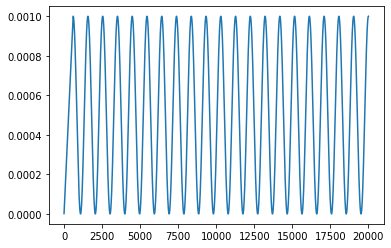

In [ ]:
lrs = []
for i in tqdm(range(20000)):
  optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
import matplotlib.pyplot as plt
plt.plot(lrs)

# Training

In [18]:
df = pd.read_csv(train_file)
freqs = [1] * dec_tokenizer.vocab_size
for response in tqdm(df['response']):
  tknzd = dec_tokenizer.encode(response)
  for tkn in tknzd:
    freqs[tkn] += 1

In [19]:
def get_weights(_lambda = 0):
  weights = torch.ones(dec_tokenizer.vocab_size)
  # for idx, freq in enumerate(freqs):
  #   weight = 1 / (freq**_lambda)
  #   weights[idx] = weight
  return weights

In [20]:
import torch.nn

weight = get_weights().to(dev)

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  # cold
  #T = 1
  #model_output = model_output / T

  if 'easy_training' in kwargs:
    print("Easy training")
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(weight=weight, ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [21]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  #kwargs = {'easy_training':4}
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader), leave=False):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':8,'num_return_sequences':8,'temperature':1,
            'no_repeat_ngram_size':3}
  #kwargs = {}
  valid_inference(**kwargs)

  print("most greedy sentence:")
  kwargs = {
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          'top-k':1
          }
  #kwargs = {}
  valid_inference(**kwargs)

  # print("temperature is 2:")
  # kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':2}
  # valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=500, **kwargs):
  hk_pair =  train_dataset[idx]['input_pair'].to(dev)
  hk_segment = train_dataset[idx]['input_pair_segments'].to(dev)
  response = train_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [ ]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/L-6-6_H-128_Plus/"
  step = 0
  log_list = []

In [22]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/L-6-6_H-128_Plus"
checkpoint = torch.load(model_dir+'/montazeri_52500steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

52500


In [23]:
from tqdm.auto import tqdm

MAX_STEP = 100000
STEP_SAVE = 500
STEP_CHECK = 500
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader), leave=False):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      train_losses = [step['train_loss'] for step in log_list[-100:]]
      avg_train_loss = sum(train_losses) / len(train_losses)
      print("train Loss rate: {} at step {}".format(avg_train_loss, step_num))  
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict()
            }, model_dir+'/montazeri_{}steps.model'.format(step_num))
    step_num += 1

52501


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is a broad term for any drinking of alcohol [

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i agree, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for a

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a b

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] alcoholism is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol related health problems
model says:  [CLS] alcoholism is also known as alcohol use disorder ( aud ) [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol and phys

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), also known as
model says:  [CLS] it is a broad term for any drinking of alcohol that occur in mental or physical health problems.
model says:  [CLS] it is a broad term for any drinking of alcohol [SE

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol that causes physical
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol and physical health
model says:  [CLS] yes, also know

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] its a broad term for any drinking of alcohol use disorder ( aud ), is a broad
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), also known as
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad te

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] alcoholism is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] i agree, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism is also known as alcohol use disorder ( aud ) [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism is a broad term for any drinking o

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), also known as
model says:  [CLS] its a broad term for any drinking of alcohol use disorder ( aud ), is a broad
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol use disorder ( aud ), also known as
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broa

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), also known as
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] its a broad term for any drinking of alcohol u

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term [SEP]
model says:  [CLS] yea its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broa

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it's also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ) [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term us

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ) [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ) [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ) [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad ter

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term used
most greedy s

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drink
model says:  [CLS] it is a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud )

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ),

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), also known as
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] it is also known as alcohol use disorder ( aud 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] it is a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] yea its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ) [SE

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), also k

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] it is a broad term for any drinki

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] its a broad term

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that causes
model says:  [CLS] it is a broad term for any drinking of alcohol [SEP] [SE

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol that occur in
model says:  [CLS] yea its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol us

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that causes
model says:  [CLS] alcoholism use disorder 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol that occur in
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol that causes physical
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that causes
model

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism. also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol and physical
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol and physical health
model says:  [CL

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol related disorders
model says:  [CLS] yea its a broad term fo

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] yea its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is a broad term for any drinking of alcohol that occur in mental or physical health proble

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol and physical
model says:  [CLS] its a bro

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that causes
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] i know, also known as alc

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] i like to drink alcohol use disorder ( aud ), is a broad term for any drinking
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems [SEP] [SEP]
model says:  [CLS] you know, also k

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i agree, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term used
most greedy

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] you know, also known as alcohol 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] you know

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] alcoholism is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that causes
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol and physical
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i agree, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i hate alcoholism. also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] i agree, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ),

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i hate alcoholism. also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol that causes physical
model says:  [CLS] alcohol

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i hate alcoholism. also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i hate alcoholism. also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] you know, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems [SEP] [SEP]
model says:  [CLS] yea, also known as alc

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] i hate alcoholism, also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] i hate alcoholism. also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that causes
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that occur
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that is
model says: 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] its a broad term for any drinking of alcohol [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i'm also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol used disorder ( aud ), is a broad
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems [SEP] [SEP]
model says:  [CLS] i know, also known as alc

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] you know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems. [SEP]
model says:  [CLS] its a broad term for any drinking of alcohol that occur in mental or physical health problems [SEP] [SEP]
model says:  [CLS] you know, also known as alco

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i'm also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol [SEP] [SEP]
model says:  [CLS] yea, also known as alcohol use disorder ( aud ) is a broad term for any
model says:  [CLS] alcoholism use disorder ( aud ) is a broad term for any drinking of alcohol [SEP] [SEP] [SEP]
model says:  [CLS] alcoholism use disorder ( aud ), is a broad term for any drinking of alcohol that causes
model says:  [CLS] yea, also known as alcohol use disorder ( a

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] i know that is also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term used
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term [SEP]
most greedy s

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] alcoholism [SEP] alcoholism, also known as alcohol use disorder ( aud ), is a broad term for any drinking of alcohol that results in mental or physical health problems. [SEP]
response is:  [CLS] i enjoy drinking alcohol too much. [SEP]
model says:  [CLS] yes, also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] it is also known as alcohol use disorder ( aud ), is a broad term for any
model says:  [CLS] i know that is also known as alcohol use disorder ( aud ), is a broad term
model says:  [CLS] yes, also known as alcohol use disorder ( aud ) is a broad term for any drinking
model says:  [CLS] yea its also known as alcohol use disorder ( aud ), is a broad term for
model says:  [CLS] yea, also known as alcohol use disorder ( aud ), is a broad term used
most greed

KeyboardInterrupt: ignored

In [27]:
kwargs = {'num_beams':1,
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':2,
          #'top-k':3,
          'top-p':0.95,
          #'do_sample':True
          }
#kwargs = {}
valid_inference(idx=1200, **kwargs)

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] we don't have peaks like that on the east coast where i'm from. [SEP] i hear that there are elevation contours that follow the length of the sierra nevada [SEP] yup. there are contours everywhere. they just describe and show a change of elevation of a surrounding landscape. [SEP] did you see any interesting plants and animals? [SEP] we saw a few bears. that was probably the most interesting. have you ever seen one in the wild before? [SEP] the brown bear ( " ursus arctos " ) is the most widely distributed bear and is found across much of northern eurasia and north america. [SEP]
response is:  [CLS] no, was it a brown bear? [SEP]
model says:  [CLS] no, i was too! [SEP]


In [32]:
kwargs = {'num_beams':8,
          'num_return_sequences':4,'temperature':1,'min_length':30,
          'max_length':100, 'early_stopping':True,
          'no_repeat_ngram_size':1,
          #'top-k':1,
          #'do_sample':True
          }
history = "Tell me about your best friend! [SEP] my best friend is habibi [SEP] What is his religion? [SEP]"
knowledge = "habibi is a muslim boy"
history_tokenized = enc_tokenizer.encode(history)
knowledge_tokenized = enc_tokenizer.encode(knowledge)
generateds = model.generate(torch.LongTensor(history_tokenized + knowledge_tokenized).to(dev),
               torch.LongTensor([0]*len(history_tokenized) + [1]*len(knowledge_tokenized)).to(dev),
               **kwargs)
dec_tokenizer.batch_decode(generateds)

["[CLS] haha, it is a social deal with the name of na - he's not sure how many people are talking about him and know. [SEP] [SEP]",
 "[CLS] haha, it is a social deal with the name of na - he's not sure how many people are talking about him lorriers [SEP] [SEP]",
 "[CLS] haha, it is a social deal with the name of na - he's not sure how many people are talking about him lorriers ) [SEP]",
 "[CLS] haha, it is a social deal with the name of na - he's not sure how many people are talking about him lon. [SEP] [SEP]"]

In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

model.eval()

f_scores = []
for i in tqdm(range(len(test_seen_dataset))):
  kwargs = {'num_beams':1,
            'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':1,
            #'top-k':1
            }
  #kwargs = {}
  hk_pair =  test_seen_dataset[i]['input_pair'].to(dev)
  hk_segment = test_seen_dataset[i]['input_pair_segments'].to(dev)
  response = test_seen_dataset[i]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  intersections = np.intersect1d(generateds, response)
  recall = len(intersections) / len(response)
  precision = len(intersections) / len(generateds)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f_scores.append(f1_score)
  if i % 100 == 0 :
    print( sum(f_scores) / len(f_scores))
print( sum(f_scores) / len(f_scores))

0.39999999999999997
